# Import the Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import pandas as pd

# File names (adjust paths if needed)
file_names = [
    "compoundV2_transactions_ethereum_chunk_1.json",
    "compoundV2_transactions_ethereum_chunk_2.json",
    "compoundV2_transactions_ethereum_chunk_3.json"
]

# List to collect standardized/flattened records from all files
all_records = []

# Loop through each file
for file in file_names:
    with open(file, "r") as f:
        raw_data = json.load(f)

    # For each transaction type (deposits, withdraws, etc.)
    for tx_type, tx_list in raw_data.items():
        for tx in tx_list:
            # Add a column to tag the transaction type
            tx['tx_type'] = tx_type
            all_records.append(tx)

# Create single merged DataFrame
final_df = pd.DataFrame(all_records)

# (Optional) Expand nested fields like account.id, asset.symbol
final_df['account_id'] = final_df['account'].apply(lambda x: x['id'] if isinstance(x, dict) else None)
final_df['asset_symbol'] = final_df['asset'].apply(lambda x: x['symbol'] if isinstance(x, dict) else None)

# Drop nested fields if not needed
final_df.drop(columns=['account', 'asset'], inplace=True, errors='ignore')

# View result
final_df.head()


,amount,amountUSD,hash,id,timestamp,tx_type,liquidatee,liquidator,account_id,asset_symbol
0,293025918296213842664,294.0983621836819788956615262405873,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,1562192556,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI
1,233591042300947866741,236.9361341141271474225646084313364,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,1562192990,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI
2,493866984581287182336,498.0440189187602102810198714990311,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,1562193000,deposits,NaN,NaN,0x3eab4037a2e7f4d4d0946c091fe135838221f2b6,DAI
3,300000000,300,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,1562193019,deposits,NaN,NaN,0x794ad3af58b56522b80aa7e9bc04f042c55d5b2f,USDC
4,476901862957734543875,476.0201479897068075625942571528157,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,1562193418,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI


# First Normalize the amount

In [3]:
# Convert amount column to numeric (if not already)
final_df['amount'] = pd.to_numeric(final_df['amount'], errors='coerce')

# Common token decimals for Compound V2 assets
TOKEN_DECIMALS = {
    'DAI': 18,
    'USDC': 6,
    'ETH': 18,
    'BAT': 18,
    'ZRX': 18,
    'REP': 18,
    'WBTC': 8,
    'USDT': 6,
    'TUSD': 18,
    'UNI': 18,
    'MKR': 18,
    'SUSHI': 18,
    'LINK': 18,
    'USDP': 18,
    'FEI': 18,
    'AAVE': 18,
    'YFI': 18,
    'COMP': 18
}


# Define function to normalize amount based on token
def normalize_amount(row):
    decimals = TOKEN_DECIMALS.get(row['asset_symbol'], 18)  # default to 18
    return row['amount'] / (10 ** decimals)

# Apply the function
final_df['normalized_amount'] = final_df.apply(normalize_amount, axis=1)

In [4]:
final_df

,amount,amountUSD,hash,id,timestamp,tx_type,liquidatee,liquidator,account_id,asset_symbol,normalized_amount
0,2.930259e+20,294.0983621836819788956615262405873,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,1562192556,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,293.025918
1,2.335910e+20,236.9361341141271474225646084313364,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,1562192990,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,233.591042
2,4.938670e+20,498.0440189187602102810198714990311,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,1562193000,deposits,NaN,NaN,0x3eab4037a2e7f4d4d0946c091fe135838221f2b6,DAI,493.866985
3,3.000000e+08,300,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,1562193019,deposits,NaN,NaN,0x794ad3af58b56522b80aa7e9bc04f042c55d5b2f,USDC,300.000000
4,4.769019e+20,476.0201479897068075625942571528157,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,1562193418,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,476.901863
...,...,...,...,...,...,...,...,...,...,...,...
130732,1.100000e+21,1109.3411228926555672,0x6aa9c75117fe9c13ade0ea0a60b2029612fa6af492bf...,0x6aa9c75117fe9c13ade0ea0a60b2029612fa6af492bf...,1593000496,repays,NaN,NaN,0x7e118a15c43b8f56cf69a4536fdd2404ac457552,DAI,1100.000000
130733,1.569169e+23,39546.03647018768654465439488882494,0x85f4dc07abc8d8d545e429f60a10703e6620a196a219...,0x85f4dc07abc8d8d545e429f60a10703e6620a196a219...,1593000570,repays,NaN,NaN,0xd5cdf14af5477adceabca130caaafd6feca56937,BAT,156916.907711
130734,1.504317e+23,37911.63419562170812067281466033884,0xa743442de20b4b4a8fd3d3813caaa8d71e6a98b0a9a8...,0xa743442de20b4b4a8fd3d3813caaa8d71e6a98b0a9a8...,1593002353,repays,NaN,NaN,0x89f4e4be0a78a63f12be3094d35fb58430d10a86,BAT,150431.672431
130735,9.990023e+20,1007.485708685064645779014562552341,0xb365f23ae8cdd5f320812e9f3f52ed8c938c38f2a4e5...,0xb365f23ae8cdd5f320812e9f3f52ed8c938c38f2a4e5...,1593003077,repays,NaN,NaN,0xa511d16826069baf6925e90950701ab01351bfc6,DAI,999.002252


In [5]:
# Drop the original 'amount' column since it's now normalized
final_df.drop(columns=['amount'], inplace=True)

# Clean amountUSD

In [6]:
# Step 1: Convert amountUSD to numeric (float), coerce errors to NaN
final_df['amountUSD'] = pd.to_numeric(final_df['amountUSD'], errors='coerce')

# Step 2: Round to 4 decimal places
final_df['amountUSD'] = final_df['amountUSD'].round(4)

In [7]:
final_df

,amountUSD,hash,id,timestamp,tx_type,liquidatee,liquidator,account_id,asset_symbol,normalized_amount
0,294.0984,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,1562192556,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,293.025918
1,236.9361,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,1562192990,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,233.591042
2,498.0440,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,1562193000,deposits,NaN,NaN,0x3eab4037a2e7f4d4d0946c091fe135838221f2b6,DAI,493.866985
3,300.0000,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,1562193019,deposits,NaN,NaN,0x794ad3af58b56522b80aa7e9bc04f042c55d5b2f,USDC,300.000000
4,476.0201,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,1562193418,deposits,NaN,NaN,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,476.901863
...,...,...,...,...,...,...,...,...,...,...
130732,1109.3411,0x6aa9c75117fe9c13ade0ea0a60b2029612fa6af492bf...,0x6aa9c75117fe9c13ade0ea0a60b2029612fa6af492bf...,1593000496,repays,NaN,NaN,0x7e118a15c43b8f56cf69a4536fdd2404ac457552,DAI,1100.000000
130733,39546.0365,0x85f4dc07abc8d8d545e429f60a10703e6620a196a219...,0x85f4dc07abc8d8d545e429f60a10703e6620a196a219...,1593000570,repays,NaN,NaN,0xd5cdf14af5477adceabca130caaafd6feca56937,BAT,156916.907711
130734,37911.6342,0xa743442de20b4b4a8fd3d3813caaa8d71e6a98b0a9a8...,0xa743442de20b4b4a8fd3d3813caaa8d71e6a98b0a9a8...,1593002353,repays,NaN,NaN,0x89f4e4be0a78a63f12be3094d35fb58430d10a86,BAT,150431.672431
130735,1007.4857,0xb365f23ae8cdd5f320812e9f3f52ed8c938c38f2a4e5...,0xb365f23ae8cdd5f320812e9f3f52ed8c938c38f2a4e5...,1593003077,repays,NaN,NaN,0xa511d16826069baf6925e90950701ab01351bfc6,DAI,999.002252


# Convert and Parse timestamp to datetime

In [8]:
# Convert timestamp to datetime format
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'], unit='s')

In [9]:
final_df.dtypes

amountUSD                   float64
hash                         object
id                           object
timestamp            datetime64[ns]
tx_type                      object
liquidatee                   object
liquidator                   object
account_id                   object
asset_symbol                 object
normalized_amount           float64
dtype: object

# Handle Missing Values

In [10]:
# Drop rows with missing 'account_id' as they can't be scored
final_df = final_df.dropna(subset=['account_id'])

# Optional: fill NaNs in 'liquidator' and 'liquidatee' with 'None' for string analysis
final_df['liquidator'] = final_df['liquidator'].fillna('None')
final_df['liquidatee'] = final_df['liquidatee'].fillna('None')


In [11]:
final_df

,amountUSD,hash,id,timestamp,tx_type,liquidatee,liquidator,account_id,asset_symbol,normalized_amount
0,294.0984,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,0xc07a5d8ca08cd1e01a8324d6235da1df7d58720500ce...,2019-07-03 22:22:36,deposits,None,None,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,293.025918
1,236.9361,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,0x11734b04bcd03f2cde375e4d13fafab9d17eef3d7aef...,2019-07-03 22:29:50,deposits,None,None,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,233.591042
2,498.0440,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,0xe611412cb9164421a95070e96b041ee12fca19a04aaa...,2019-07-03 22:30:00,deposits,None,None,0x3eab4037a2e7f4d4d0946c091fe135838221f2b6,DAI,493.866985
3,300.0000,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,0xcb7f5145eb6779cd18789251094f20587e357adb0f6e...,2019-07-03 22:30:19,deposits,None,None,0x794ad3af58b56522b80aa7e9bc04f042c55d5b2f,USDC,300.000000
4,476.0201,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,0xc0809ef3102b874c7d55aafb6abddf8b8f5cbe743197...,2019-07-03 22:36:58,deposits,None,None,0x9e21d7f1d1878be7e4e5f0c8750b09b09414be44,DAI,476.901863
...,...,...,...,...,...,...,...,...,...,...
130732,1109.3411,0x6aa9c75117fe9c13ade0ea0a60b2029612fa6af492bf...,0x6aa9c75117fe9c13ade0ea0a60b2029612fa6af492bf...,2020-06-24 12:08:16,repays,None,None,0x7e118a15c43b8f56cf69a4536fdd2404ac457552,DAI,1100.000000
130733,39546.0365,0x85f4dc07abc8d8d545e429f60a10703e6620a196a219...,0x85f4dc07abc8d8d545e429f60a10703e6620a196a219...,2020-06-24 12:09:30,repays,None,None,0xd5cdf14af5477adceabca130caaafd6feca56937,BAT,156916.907711
130734,37911.6342,0xa743442de20b4b4a8fd3d3813caaa8d71e6a98b0a9a8...,0xa743442de20b4b4a8fd3d3813caaa8d71e6a98b0a9a8...,2020-06-24 12:39:13,repays,None,None,0x89f4e4be0a78a63f12be3094d35fb58430d10a86,BAT,150431.672431
130735,1007.4857,0xb365f23ae8cdd5f320812e9f3f52ed8c938c38f2a4e5...,0xb365f23ae8cdd5f320812e9f3f52ed8c938c38f2a4e5...,2020-06-24 12:51:17,repays,None,None,0xa511d16826069baf6925e90950701ab01351bfc6,DAI,999.002252


# Feature Engineering — Create Behavior Features per Wallet

In [12]:
# Group by account_id to build wallet-level behavioral features
wallet_features = final_df.groupby('account_id').agg(
    total_txns=('tx_type', 'count'),
    total_deposits=('tx_type', lambda x: (x == 'deposits').sum()),
    total_borrows=('tx_type', lambda x: (x == 'borrows').sum()),
    total_withdraws=('tx_type', lambda x: (x == 'withdraws').sum()),
    total_repays=('tx_type', lambda x: (x == 'repays').sum()),
    total_liquidations=('tx_type', lambda x: (x == 'liquidation').sum()),
    total_normalized_amount=('normalized_amount', 'sum'),
    avg_normalized_amount=('normalized_amount', 'mean'),
    active_days=('timestamp', lambda x: (x.max() - x.min()).days + 1),
    first_txn=('timestamp', 'min'),
    last_txn=('timestamp', 'max')
).reset_index()


In [13]:
wallet_features

,account_id,total_txns,total_deposits,total_borrows,total_withdraws,total_repays,total_liquidations,total_normalized_amount,avg_normalized_amount,active_days,first_txn,last_txn
0,0x00000000af5a61acaf76190794e3fdf1289288a1,97,0,0,73,24,0,9.607937e+04,990.509015,133,2019-08-14 17:21:40,2019-12-25 06:34:40
1,0x00000000b1786c9698c160d78232c78d6f6474fe,30,0,0,0,30,0,2.884796e+04,961.598670,111,2020-02-12 20:48:55,2020-06-02 14:59:25
2,0x0000000484f2217f1a64eb6d24b5cee446faeae5,17,0,9,0,8,0,4.385511e+05,25797.124308,7,2020-06-15 20:42:54,2020-06-22 16:46:12
3,0x000000aaee6a496aaf7b7452518781786313400f,312,70,59,94,89,0,4.126592e+06,13226.255009,260,2019-07-03 23:17:50,2020-03-19 20:00:58
4,0x000206732258d7511fa624127228e6a032718e62,1,0,0,1,0,0,2.568006e+02,256.800571,1,2019-10-01 08:28:37,2019-10-01 08:28:37
...,...,...,...,...,...,...,...,...,...,...,...,...
17141,0xfff801e0bf28c9582420eeec66830c69c5670159,178,71,0,107,0,0,2.643958e+03,14.853696,33,2019-07-26 14:01:11,2019-08-27 23:31:00
17142,0xfff95dea424c0d7a25471982610a2485f302fb54,2,2,0,0,0,0,2.737893e+01,13.689463,35,2019-07-24 03:21:59,2019-08-27 05:00:11
17143,0xfffa404fbfe29adae17d7900b3740367a1247fbb,1,1,0,0,0,0,9.726352e+03,9726.352393,1,2019-08-21 21:28:30,2019-08-21 21:28:30
17144,0xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,3,2,0,0,1,0,2.262781e+02,75.426023,153,2019-08-30 10:36:17,2020-01-29 18:12:14


# Additional Derived Features

In [14]:
# Add ratios and frequencies
wallet_features['deposit_ratio'] = wallet_features['total_deposits'] / wallet_features['total_txns']
wallet_features['borrow_ratio'] = wallet_features['total_borrows'] / wallet_features['total_txns']
wallet_features['repay_ratio'] = wallet_features['total_repays'] / wallet_features['total_txns']
wallet_features['withdraw_ratio'] = wallet_features['total_withdraws'] / wallet_features['total_txns']
wallet_features['liquidation_ratio'] = wallet_features['total_liquidations'] / wallet_features['total_txns']
wallet_features

,account_id,total_txns,total_deposits,total_borrows,total_withdraws,total_repays,total_liquidations,total_normalized_amount,avg_normalized_amount,active_days,first_txn,last_txn,deposit_ratio,borrow_ratio,repay_ratio,withdraw_ratio,liquidation_ratio
0,0x00000000af5a61acaf76190794e3fdf1289288a1,97,0,0,73,24,0,9.607937e+04,990.509015,133,2019-08-14 17:21:40,2019-12-25 06:34:40,0.000000,0.000000,0.247423,0.752577,0.0
1,0x00000000b1786c9698c160d78232c78d6f6474fe,30,0,0,0,30,0,2.884796e+04,961.598670,111,2020-02-12 20:48:55,2020-06-02 14:59:25,0.000000,0.000000,1.000000,0.000000,0.0
2,0x0000000484f2217f1a64eb6d24b5cee446faeae5,17,0,9,0,8,0,4.385511e+05,25797.124308,7,2020-06-15 20:42:54,2020-06-22 16:46:12,0.000000,0.529412,0.470588,0.000000,0.0
3,0x000000aaee6a496aaf7b7452518781786313400f,312,70,59,94,89,0,4.126592e+06,13226.255009,260,2019-07-03 23:17:50,2020-03-19 20:00:58,0.224359,0.189103,0.285256,0.301282,0.0
4,0x000206732258d7511fa624127228e6a032718e62,1,0,0,1,0,0,2.568006e+02,256.800571,1,2019-10-01 08:28:37,2019-10-01 08:28:37,0.000000,0.000000,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17141,0xfff801e0bf28c9582420eeec66830c69c5670159,178,71,0,107,0,0,2.643958e+03,14.853696,33,2019-07-26 14:01:11,2019-08-27 23:31:00,0.398876,0.000000,0.000000,0.601124,0.0
17142,0xfff95dea424c0d7a25471982610a2485f302fb54,2,2,0,0,0,0,2.737893e+01,13.689463,35,2019-07-24 03:21:59,2019-08-27 05:00:11,1.000000,0.000000,0.000000,0.000000,0.0
17143,0xfffa404fbfe29adae17d7900b3740367a1247fbb,1,1,0,0,0,0,9.726352e+03,9726.352393,1,2019-08-21 21:28:30,2019-08-21 21:28:30,1.000000,0.000000,0.000000,0.000000,0.0
17144,0xffff2c1d5fa3f7dc16902c3f4dfc56b138474d3e,3,2,0,0,1,0,2.262781e+02,75.426023,153,2019-08-30 10:36:17,2020-01-29 18:12:14,0.666667,0.000000,0.333333,0.000000,0.0


# Clustering Wallets (Exploratory Analysis)

In [15]:
from sklearn.preprocessing import StandardScaler

# List of numerical features we want to scale (you can update this list based on the actual columns in wallet_features)
numerical_features = [
    'total_txns', 'total_deposits', 'total_borrows', 'total_withdraws', 'total_repays',
    'total_liquidations', 'total_normalized_amount', 'avg_normalized_amount', 'active_days',
    'deposit_ratio', 'borrow_ratio', 'repay_ratio', 'withdraw_ratio', 'liquidation_ratio'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
wallet_features_scaled = scaler.fit_transform(wallet_features[numerical_features])

# Convert the scaled data back into a DataFrame
scaled_wallet_features = pd.DataFrame(wallet_features_scaled, columns=numerical_features)

# Add non-numerical columns back (if needed)
wallet_features_scaled_full = wallet_features.copy()
wallet_features_scaled_full[numerical_features] = scaled_wallet_features

# Verify the scaling
wallet_features_scaled_full.head()


,account_id,total_txns,total_deposits,total_borrows,total_withdraws,total_repays,total_liquidations,total_normalized_amount,avg_normalized_amount,active_days,first_txn,last_txn,deposit_ratio,borrow_ratio,repay_ratio,withdraw_ratio,liquidation_ratio
0,0x00000000af5a61acaf76190794e3fdf1289288a1,1.891421,-0.158080,-0.084303,7.529105,0.822408,0.0,-0.008713,-0.065704,1.593336,2019-08-14 17:21:40,2019-12-25 06:34:40,-0.896577,-0.532806,0.409520,1.025096,0.0
1,0x00000000b1786c9698c160d78232c78d6f6474fe,0.483383,-0.158080,-0.084303,-0.184891,1.044178,0.0,-0.042370,-0.065923,1.242429,2020-02-12 20:48:55,2020-06-02 14:59:25,-0.896577,-0.532806,3.191150,-0.878319,0.0
2,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0.210182,-0.158080,0.349337,-0.184891,0.231022,0.0,0.162734,0.122564,-0.416404,2020-06-15 20:42:54,2020-06-22 16:46:12,-0.896577,1.312852,1.234371,-0.878319,0.0
3,0x000000aaee6a496aaf7b7452518781786313400f,6.409750,6.166285,2.758449,9.748200,3.224915,0.0,2.009027,0.027158,3.619025,2019-07-03 23:17:50,2020-03-19 20:00:58,-0.342844,0.126451,0.549359,-0.116318,0.0
4,0x000206732258d7511fa624127228e6a032718e62,-0.126066,-0.158080,-0.084303,-0.079219,-0.064671,0.0,-0.056683,-0.071272,-0.512106,2019-10-01 08:28:37,2019-10-01 08:28:37,-0.896577,-0.532806,-0.504989,1.650876,0.0


# B. Clustering Using KMeans

In [22]:
wallet_features_scaled_full['cluster'].value_counts()

cluster
2    7678
0    5094
1    4363
3      11
Name: count, dtype: int64

In [23]:
from sklearn.cluster import KMeans

# Define the number of clusters (choose a suitable value, e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)

# # Fit the model and predict clusters
wallet_features_scaled_full['cluster'] = kmeans.fit_predict(wallet_features_scaled)

# # Check the cluster distribution
print(wallet_features_scaled_full['cluster'].value_counts())


cluster
2    7678
0    5094
1    4363
3      11
Name: count, dtype: int64


In [24]:
# Select only the numeric columns for clustering analysis
numeric_columns = wallet_features_scaled_full.select_dtypes(include='number')

# Group by the cluster and calculate the mean of the numeric columns
cluster_means = numeric_columns.groupby(wallet_features_scaled_full['cluster']).mean()

# View the mean values for each cluster
cluster_means


,total_txns,total_deposits,total_borrows,total_withdraws,total_repays,total_liquidations,total_normalized_amount,avg_normalized_amount,active_days,deposit_ratio,borrow_ratio,repay_ratio,withdraw_ratio,liquidation_ratio,cluster
cluster,,,,,,,,,,,,,,,
0,0.087162,-0.097937,0.152673,-0.084385,0.105763,0.0,0.049260,0.076138,0.249780,-0.838752,1.191288,1.146993,-0.789592,0.0,0.0
1,-0.069378,-0.121821,-0.079389,0.143869,-0.061604,0.0,-0.047105,-0.047315,-0.291086,-0.805434,-0.493195,-0.486116,1.515824,0.0,1.0
2,-0.049307,0.118706,-0.079315,-0.036266,-0.061754,0.0,-0.044115,-0.049455,-0.002107,1.015216,-0.511133,-0.486871,-0.336388,0.0,2.0
3,21.569557,10.815103,16.148734,7.327370,18.560636,0.0,26.663948,18.028005,1.255479,-0.737792,0.715172,1.485490,-0.779268,0.0,3.0


In [25]:
wallet_features_scaled_full['cluster'].value_counts()

cluster
2    7678
0    5094
1    4363
3      11
Name: count, dtype: int64

# Interpret the Clustering Results

In [28]:
wallet_features_scaled_full['cluster'].map({
    0: 50,  # Cluster 0 - low score
    1: 70,  # Cluster 1 - medium score
    2: 85,  # Cluster 2 - high score
    3: 100  # Cluster 3 - excellent score
})

0        70
1        50
2        50
3        50
4        70
         ..
17141    70
17142    85
17143    85
17144    85
17145    50
Name: cluster, Length: 17146, dtype: int64

In [29]:
# Assigning a score based on cluster number (you can adjust the scoring system as per the cluster interpretation)
# For example: higher cluster values could indicate better wallets.

wallet_features_scaled_full['credit_score'] = wallet_features_scaled_full['cluster'].map({
    0: 50,  # Cluster 0 - low score
    1: 70,  # Cluster 1 - medium score
    2: 85,  # Cluster 2 - high score
    3: 100  # Cluster 3 - excellent score
})

# You can also scale the scores to be between 0 and 100 depending on the cluster characteristics

wallet_features_scaled_full[['account_id', 'cluster', 'credit_score']].head()


,account_id,cluster,credit_score
0,0x00000000af5a61acaf76190794e3fdf1289288a1,1,70
1,0x00000000b1786c9698c160d78232c78d6f6474fe,0,50
2,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0,50
3,0x000000aaee6a496aaf7b7452518781786313400f,0,50
4,0x000206732258d7511fa624127228e6a032718e62,1,70


In [30]:
from sklearn.metrics import silhouette_score

# Silhouette score for clustering quality (ranges from -1 to 1, where higher is better)
sil_score = silhouette_score(wallet_features_scaled, wallet_features_scaled_full['cluster'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.47125428839935807


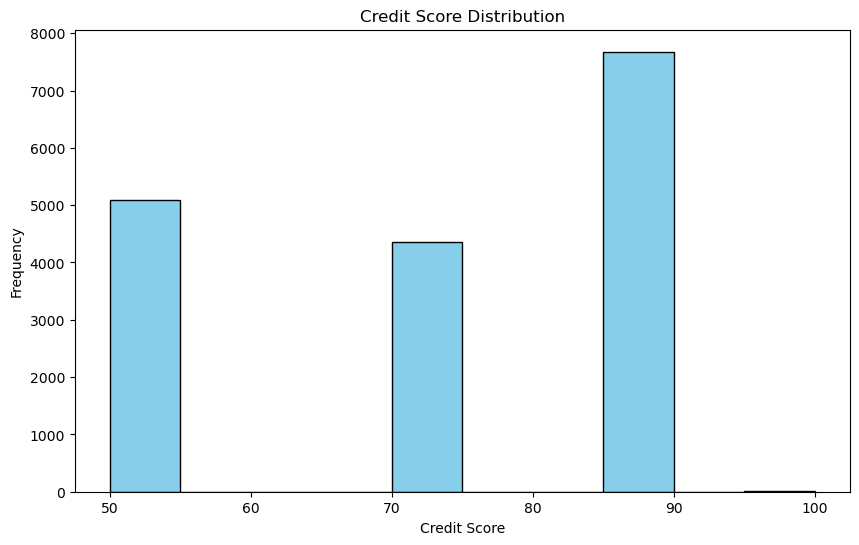

In [31]:
import matplotlib.pyplot as plt

# Plotting the distribution of credit scores
plt.figure(figsize=(10, 6))
plt.hist(wallet_features_scaled_full['credit_score'], bins=10, color='skyblue', edgecolor='black')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()


In [32]:
# Top 5 scoring wallets
top_wallets = wallet_features_scaled_full.sort_values('credit_score', ascending=False)
top_wallets.head(5)[['account_id','cluster','credit_score']]

,account_id,cluster,credit_score
10039,0x964d9d1a532b5a5daeacbac71d46320de313ae9c,3,100
4304,0x402a75f3500ca1fba17741ec916f07a0c9db195d,3,100
7834,0x7578e676b3706aa65a4d7b9bd621922a305552db,3,100
5400,0x508b01d1597379ed0f1fb84a00297e193e8daa7a,3,100
16616,0xf859a1ad94bcf445a406b892ef0d3082f4174088,3,100


In [33]:
# Bottom 5 scoring wallets
bottom_wallets = wallet_features_scaled_full.sort_values('credit_score', ascending=True)
bottom_wallets.head(5)[['account_id','cluster','credit_score']]

,account_id,cluster,credit_score
17145,0xffffa57756e1c19c1e0026487559982e721cffff,0,50
11311,0xa83c572c8072f3b11562f08b89d4f3077682acdb,0,50
11314,0xa842c58175e95f20086e3264167cbe9e22127bac,0,50
4564,0x43e2f47c9c38ffb943d6efa0771031306cb1bbb8,0,50
11316,0xa84903e504a2449ebe48aa96a82badbc906aec6a,0,50


In [34]:
# Combine the analysis
wallet_analysis = pd.concat([top_wallets[['account_id', 'credit_score']], bottom_wallets[['account_id', 'credit_score']]])

In [35]:
# Save the top 1000 wallets sorted by credit score
top_wallets = wallet_features_scaled_full[['account_id', 'credit_score']].sort_values(by='credit_score', ascending=False).head(1000)
top_wallets.to_csv('top_wallets_scores.csv', index=False)


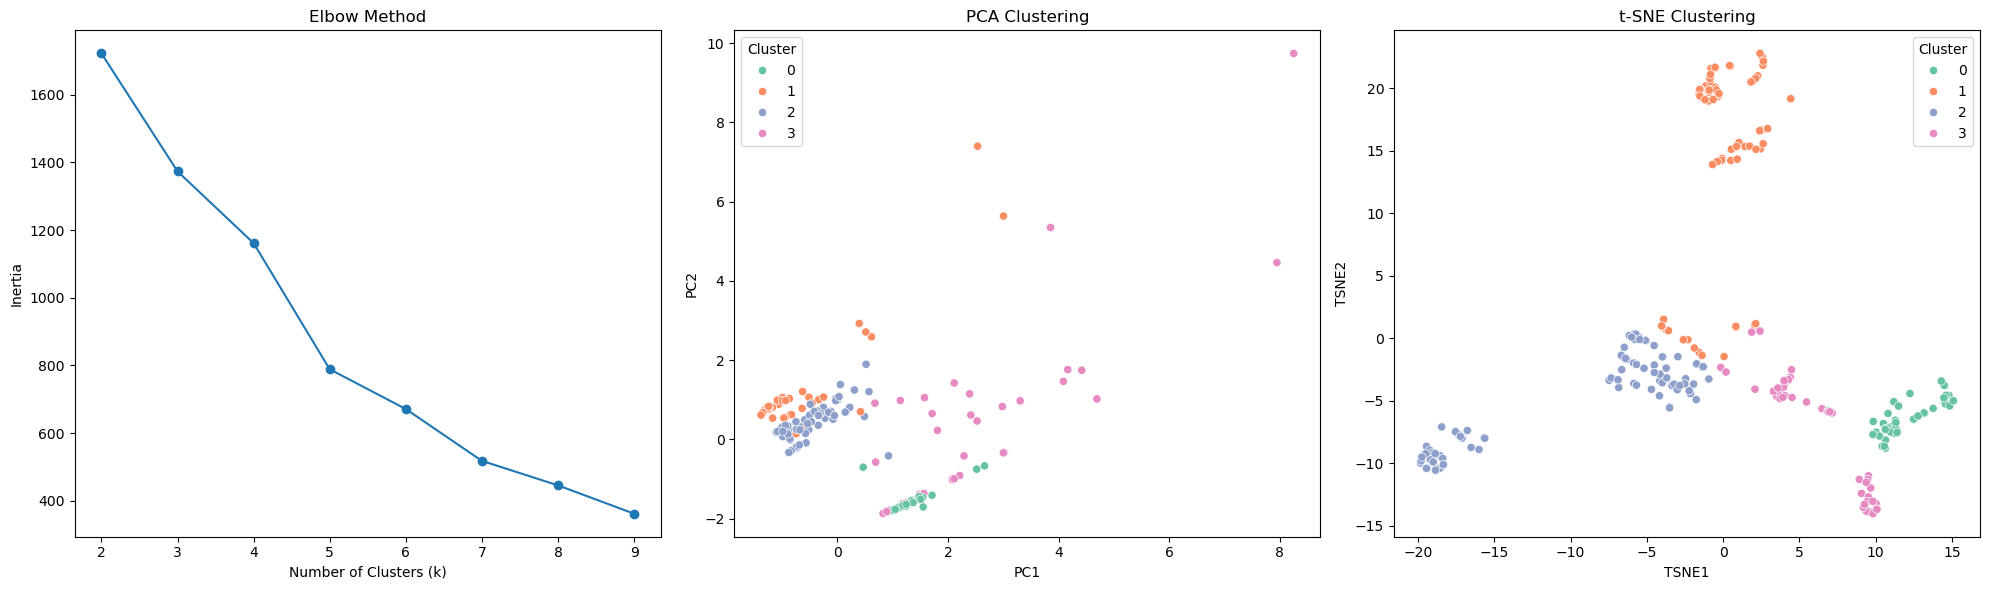

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Use your actual scaled dataset
# wallet_features_scaled = ...

# Optional: downsample if memory is limited
wallet_features_scaled_small = wallet_features_scaled[:300]

# Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=True)
    km.fit(wallet_features_scaled_small)
    inertia.append(km.inertia_)

# KMeans with optimal cluster (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=True)
clusters = kmeans.fit_predict(wallet_features_scaled_small)

# PCA
pca = PCA(n_components=2)
wallet_pca = pca.fit_transform(wallet_features_scaled_small)
pca_df = pd.DataFrame(wallet_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# t-SNE
tsne = TSNE(n_components=2, random_state=True, perplexity=30)
wallet_tsne = tsne.fit_transform(wallet_features_scaled_small)
tsne_df = pd.DataFrame(wallet_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Elbow Method
axes[0].plot(k_range, inertia, marker='o')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')

# PCA
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', ax=axes[1])
axes[1].set_title('PCA Clustering')

# t-SNE
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', ax=axes[2])
axes[2].set_title('t-SNE Clustering')

plt.tight_layout()
plt.show()
